# CW1 Company Reputation Analysis

## A. Data Collection

### The company that we have chosen to perform our sentimeny analysis is AirAsia. 

In [918]:
!pip install asyncpraw 
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.3 MB/s eta 0:00:00


We installed asyncpraw to interact with Reddit's API, and nltk for natural language processing

In [919]:
import pandas as pd

In [924]:
import re
import asyncio
import asyncpraw

async def getAirAsiaReviews(url, unrelatedKeywords):
    async with asyncpraw.Reddit(
        client_id="", 
        client_secret="", 
        user_agent="", 
        username="",
        password=""
    )as reddit:

        try:
            submission = await reddit.submission(url=url)
            await submission.comments.replace_more(limit=None)  # Load all comments
    
            airasia_reviews = []
            total_comments = 0  # Counter for all comments & subcomments
    
            async def process_comment(comment):
                """ Recursively process a comment and its replies """
                nonlocal total_comments
                total_comments += 1  # Count this comment
    
                comment_text = comment.body.strip()
    
                # Check comment conditions
                if len(comment_text.split()) > 1 and not any(re.search(keyword, comment_text, re.IGNORECASE) for keyword in unrelatedKeywords):
                    airasia_reviews.append(comment_text)
    
                # Fetch and process replies
                await comment.replies.replace_more(limit=None)  # Ensure all replies are loaded
                for reply in comment.replies:
                    await process_comment(reply)  # Recursively process each reply
    
            # Process all top-level comments
            for top_comment in submission.comments:
                await process_comment(top_comment)
    
            return airasia_reviews, total_comments  # Return reviews & total count
    
        except asyncpraw.exceptions.APIException as e:
            print(f"API Error: {e}")
        except Exception as e:
            print(f"An error occurred: {e.__class__.__name__}: {e}")
        return [], 0

This asynchronous function getAirAsiaReviews retrieves all comments from a given Reddit post URL using asyncpraw, filters out unrelated comments based on keywords, and returns a list of relevant AirAsia reviews along with the total number of comments processed. 

In [944]:
import asyncio
import csv
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

async def processUrls(urls_with_keywords):
    sia = SentimentIntensityAnalyzer()  # Initialize sentiment analyzer
    all_reviews = []
    total_comments_count = 0  

    # Create tasks with corresponding keywords for each URL
    tasks = [getAirAsiaReviews(url, keywords) for url, keywords in urls_with_keywords]
    results = await asyncio.gather(*tasks)  # Get results

    for reviews, count in results:
        for review in reviews:
            # Get sentiment score
            sentiment_score = sia.polarity_scores(review)["compound"]

            # Classify sentiment
            if sentiment_score >= 0.55:
                sentiment = "Positive"
            elif sentiment_score <= -0.55:
                sentiment = "Negative"
            else:
                sentiment = "Neutral"

            all_reviews.append((review, sentiment))  # Store review with label
        total_comments_count += count  

    print(f"Total Comments (including subcomments): {total_comments_count}")  
    print(f"Filtered Comments: {len(all_reviews)}")  

    # Save to CSV
    filename = "AirAsiaComments.csv"
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Review", "Sentiment"])  # CSV header

        for review, sentiment in all_reviews:
            writer.writerow([review, sentiment])  # Save each review with label

    print(f"Saved {len(all_reviews)} labeled reviews to {filename}")



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


This asynchronous function processUrls retrieves comments from multiple Reddit URLs, analyzes their sentiment using VADER, and saves the labeled reviews in a CSV file. It gathers comments using getAirAsiaReviews, assigns a sentiment label (Positive, Neutral, or Negative) based on sentiment scores, and writes the results to AirAsiaComments.csv.

In [946]:
urls_with_keywords = [
    ("https://www.reddit.com/r/travel/comments/1fr6bdo/experience_with_airasia/", ["bummer", "Korea", "covid", r"\?$","How can airline be"]),
    ("https://www.reddit.com/r/Flights/comments/1dy6pc5/is_airasia_good/", ["subreddit", "advertisement",r"3-3","fatal","A330","booking.com","A320","different?","narrowbody"]),
    ("https://www.reddit.com/r/malaysia/comments/1cbt207/chinese_tourist_gets_scolded_bodoh_by_airasia/", ["european","filter","chinese","MAS","bots","POV",r"\#","jobless","tambang","sanusi","tiong","padan","viral","China","Shanghai","spit","Perchance","apples","character's","ignorant","bat","print","B40","customer service","doomerism","1st","check-in","bikin","content","mainlanders","amoi","flipping","America","downvoted","imaginary","MAVCOM","fitness","transaction","not her","enforcement","one of them","smart","incase","I agree","scenario","Depends",]),
    ("https://www.reddit.com/r/malaysia/comments/yiauxn/whats_your_opinion_on_airasia/", ["Period",r"\?$","engine problem","generator","murah"]),
    ("https://www.reddit.com/r/travel/comments/18lvddo/air_asia_is_shit/", ["bullet","purchase..","incentivized","To be fair","Vietjet enters","bro scoot","bus now","stripped-down","plain wrong","plane wrong","settle claims","accommodation","http","Fair enough","Cathay","regional","spot on","advice","NSW","Western","Canberra","nautical","MEL-SYD","detour","Bangkok","misguided","Emirates","actually believe","Was the","flexible","currencies","classic","TSA","vanished","It is","TRS","Curiously","low level","doodoo","weather","dignity","January","Buy travel insurance","it lol","UK","advertisement","roundtrip","compensated","0h  no"]),
    ("https://www.reddit.com/r/travel/comments/1581h8f/im_having_serious_issues_with_the_airasia_website/", ["out Trip.com","Good to know","Flyertalk","Hahah","Expedia","white","Webjet","Do you remember","How did you","1 year later","dunno","Veit","company in thailand"]),
    ("https://www.reddit.com/r/malaysia/comments/1djh936/i_dont_get_it_whats_the_hate_on_air_asia/", ["enlighten me","air france","Probably did","union","Erling","tribunal","trail","hundreds","fuk","Philippine","not illegal","hates from","Enrich","not ANA","EVA","singing FA","KL-KK","BKI-KUL","rotting","apples","ransom","Wizz","mentioned Scoot","ALL were delayed","FTFY","well done bot","LMAOOOOOOOOOO","1.6k","http","ioncare","comparison","price is not","stalking","FTW","mlm","Not sure man","mean comment","yakitori","_not_","owe them money","Vietjet","larh","Puduraya","Heathrow","poker","weighing staff","loathes","are more expensive","from changi","on the same plane","RyanAir CEO","jank","standing","British","time-sensitive","safety concerns","suicide-Ryanair","Germainwings","90s","Maswings","whataboutism","Myairline was good","relatives","Pattaya","Always delay","batik air quite","Lion","Vishnu","holly","creaking","Can share","journey next week","mahal","belum","flight/a","airlines from Indonesia","burner","on the Max"]),
    ("https://www.reddit.com/r/Flights/comments/160p0qh/is_air_asia_good/", ["http", "Thank you","Calories"]),
    ("https://www.reddit.com/r/malaysia/comments/1fo4544/airasia_named_worlds_best_budget_airline_for_15th/", ["Daily Show","and consecutively","bottom of the barrel","Etihad","rm10","better alternatives","SIA","Seoul","Will keep","cost-service-comfort","Exactly","still worth it","ANA","Lionair","Thanks","low cost","zipair","buffet","April","Tony","Most votes win","low bar"]),
    ("https://www.reddit.com/r/malaysia/comments/vh9x7d/fly_with_malaysia_airlines_or_airasia/", ["half price","rm1500","Sabah","infotainment","vent","Jetstar","EK","Singapore airlines","Thai Airways","rescheduled a month","two weeks out","AirAsia stole"]),
    ("https://www.reddit.com/r/askSingapore/comments/w5vap5/are_airasia_flights_from_singapore_safereliable/",["indo","ecommerce","conclusion","flight delays"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/18r7dtl/thai_air_asia_reliable/", ["thanks", r"\?$",]),
    ("https://www.reddit.com/r/Flights/comments/1gkdkuw/how_safe_is_airasia_cambodia/", ["http"]),
    ("https://www.reddit.com/r/AirTravelIndia/comments/1is9nir/requesting_feedback_on_malaysia_airlines_vs/", ["http","benefits of malaysian","Got it","directly","indigo","737 MAX","Couldn't agree more","judgmental","blood","Boeing","equally useless for me","Malaysia Airlines"]),
    ("https://www.reddit.com/r/malaysia/comments/1det4wy/airasia_ak857/", ["fallen","http","sorry","wishing","Officer",r"\?$","dint","pilots","7hrs","Aborted","engineers","dog","her 😂","HVAC","Thanks","tony","V1","V2","Fell off","EasyJet","triggered","disappear","2:57pm"]),
    ("https://www.reddit.com/r/fearofflying/comments/17ybh7d/flying_with_air_asia/", []),
    ("https://www.reddit.com/r/Thailand/comments/13ga3zu/airasia/", ["Thanks","email","balls","wait up","hope you","23","CC","procedure","delay"]),
    ("https://www.reddit.com/r/Flights/comments/1aixa75/airlines_to_use_while_in_asia/?q=airasia&type=comments&cId=abb031b0-a3fd-4c4e-8784-96e2d363360f&iId=5167fe72-f102-45f9-9cf5-25755aface47", [r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/malaysia/comments/191bi55/airasia_group_amongst_safest_lowcost_airlines_for/", []),
    ("https://www.reddit.com/r/travel/comments/1eqdngp/airline_companies_for_sea_travel/?q=airasia&type=comments&cId=c818bf1f-0eea-4f10-9bc5-adc56fdaba2f&iId=888012b0-a7c3-4e9e-b07c-dd293a575a80", [r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/malaysia/comments/xmmb7c/despite_getting_most_complaints_airasia_again/", ["eggs","berpisah","MAVCOM","clap","So u mean","per million passengers","worse budget airlines"]),
    ("https://www.reddit.com/r/malaysia/comments/1hvlkej/airasia_aseanmove_pass_review/", ["Ppl"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/1hvlmbs/airasia_aseanmove_pass_review/", []),
    ("https://www.reddit.com/r/Thailand/comments/108f1mq/do_not_buy_the_air_asia_super_pass/", [r"\?$","damn that","smoke","routes","20,000","Unthinkable","Frontier","Twitter","could not flights","Hawaii","baht","about that","AAirpass","cynic","take the hit","Not anymore","sacrifice","- will","How","400","for sharing","it's a good deal","money and stress"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/1doplka/australia_to_thailand_whats_better_jetstar_or_air/", [r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/Shoestring/comments/14h5xwz/cheapest_airports_to_get_to_asia_from_mainland_us/?q=airasia&type=comments&cId=c818bf1f-0eea-4f10-9bc5-adc56fdaba2f&iId=74872392-fe69-483a-82ee-5c38e568d841", [r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/Flights/comments/1clnaom/peach_and_other_asian_low_cost_carriers/?q=airasia&type=comments&cId=c818bf1f-0eea-4f10-9bc5-adc56fdaba2f&iId=a281fdb8-da9c-4609-863c-b773ebe43fba",[r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/QantasAirways/comments/1d7swy4/australia_to_thailand_whats_a_better_budget/", ["scoot","Ramadan",r"\?$","Airbus","Singapore Airlines","third or fourth city","sale","bot","Australian","JQ","Gold Coast"]),
    ("https://www.reddit.com/r/phtravel/comments/16p1k8m/should_i_book_airasia/", ["thank you", "OP", "PAL","pal", "thanksss", "sorry", "ang", "hindi", "bat","thankss","kung","maayos"]),
    ("https://www.reddit.com/r/AirAsia/comments/1iqokx6/cancelled_flights/", []),
    ("https://www.reddit.com/r/malaysia/comments/1heqoz1/airasia_truly_asia/", ["PAL", "thanks!", "AIR JAPAN", "Narita", "ANA", "beer", "insurance", "merger", "DJ", "motto","http","capsules","observatory","10am","Vindicated","transport ministry","200 to 300",r"\?$"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/yzwxy6/airasia_trustworthy/", ["guy", "Samui", "thank you", "Piggybacking", "Worldwilde", "advtrilys",r"\?$","Technical it's the total weight"]),
    ("https://www.reddit.com/r/Advice/comments/1dy6qfb/is_airasia_good/", []),
    ("https://www.reddit.com/r/ThailandTourism/comments/vn84xm/airasia_experience/", ["Malindo", "VietJet", "I was 🙏", "Thank you", "Visas", "peculiar", "lesson", "BK", "(KUL)", "posting", "lesson"]),
    ("https://www.reddit.com/r/malaysia/comments/157y5mj/current_state_and_reliability_of_air_asia/", ["thanks"]),
    ("https://www.reddit.com/r/Flights/comments/1i0bvg2/airasia_is_crappy_shitty_worst_airline_avoid_them/", ["Notice"]),
    ("https://www.reddit.com/r/Flights/comments/1da1sws/airasia_unlimited_pass_misleading_and_total_scam/", ["dispute"]),
    ("https://www.reddit.com/r/Kazakhstan/comments/1cxve2k/anyone_fly_airasia_to_kuala_lumpur/", ["luggage", "MOVE", "MDAC", "Thanks", "Wait"]),
    ("https://www.reddit.com/r/malaysia/comments/18posov/why_do_people_bash_so_much_airasia_but_still_fly/", ["MAS", "hypocritical", "carrier", "Newsflash", "Haha", "Malindo", "bus", "you pay with your time", "KLIA2", 
                                                                                                             "JB", "festive", "envy", "skinny", "scoot", "chubbier", "monopoly", "sliding", "shallow", "benci", "complain", 
                                                                                                             "charge", "dumb", "kiddo", "vendor", "cheapo", "Tony", "exorbitant", "cool", "messaur", "Vietnam", "beggars", 
                                                                                                             "PAS", "rm22m", "king", "bashing", "which is it", "Qantas", "love-hate","DAP", "OP's", "bash", "shut up", "But..."]),
    ("https://www.reddit.com/r/malaysia/comments/1fo4544/airasia_named_worlds_best_budget_airline_for_15th/", ["Spirit", "barrel", "Japan", "SIA", "KUL", "thanks", "Batik's", 
                                                                                                              "Nov", "ANA", "Thanks!", "aren't", "Tony", "Batik", "perspective", 
                                                                                                              "bar", "Changi", "theatre", "Singapore"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/1irvlq8/any_experience_with_air_asia/", ["emergency", "6'1", "Thailand", "standard", "Windows", "adapter", "depressing", "tech", "gym", "You're", 
                                                                                                "Thai", "plus sized", "overweight", "third", "Bangkok", "electronics", "screwed" ]),
    ("https://www.reddit.com/r/Thailand/comments/zii4a2/airasia_canceling_flights_like_crazy/", ["FYI", "NokAir", "Thailand", "effing", "SQ", "chasing", "shove", "physical", "bugging", 
                                                                                                "puttingoff", "Thai", "Malaysian", "DMK", "companies"]),
    ("https://www.reddit.com/r/Flights/comments/1hrjfuq/a_disappointing_experience_with_air_asia_the/", ["agreeing", "probably", "ULCC"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/1bvllc9/airasia_flight_changes_beyond_48hrs/", ["friends"]),
    ("https://www.reddit.com/r/travel/comments/1ai1bmh/book_with_air_asia_at_your_own_risk/", ["CAD", "discharge", "partner", "LCC", "credit card", "awful"]),
    ("https://www.reddit.com/r/malaysia/comments/1czy382/airasia_doublebooked_my_flight_canceled_the_wrong/", ["contact", "duplicate", "tabole", "OP", "keyword", "intentionally", "says...", "DM"]),
    ("https://www.reddit.com/r/TravelHacks/comments/1dcxssa/how_common_are_air_asia_delays_and_cancellations/", ["OTP", "OP"]),
    ("https://www.reddit.com/r/Thailand/comments/2fbvtq/is_air_asia_legit/", ["OTP", "OP", "Thanks", "remove" "SEA", "Cool!", "Thailand", "dick", "promotion", "shady"]),
    ("https://www.reddit.com/r/malaysia/comments/1b0apll/airasia_move_debuts_with_refreshed_app_look/", []),
    ("https://www.reddit.com/r/newzealand/comments/142bk8l/airasia_flights/", ["thanks"]),
    ("https://www.reddit.com/r/indonesia/comments/1aiw8vj/would_you_fly_air_asia_indo/", ["thanks", "lcc", "lion", "zero", "pedestrians", "setuju", "gua", "garuda", 
                                                                                         "Boeing", "so,", "737", "lol", "matter", "kaum mendang" ]),
    ("https://www.reddit.com/r/malaysia/comments/z8kvqv/air_asia/", ["MAS", "stockholm", "true", "lah", "bank"]),
    ("https://www.reddit.com/r/malaysia/comments/uc4jja/is_airasia_a_zombie_company_they_dont_seem_to_be/", ["Australia", "operation", "credit", "Cattle", "plausible", "live agent", "Ughh", "trashiest", "VTL", 
                                                                                                            "curious", "vtubers", "bf", "Mikazuki", "nah", "God", "Khazanah", "afloat", "VTuber", "Subang", 
                                                                                                            "sorry", "OP", "dumb", "retimed", "zombie"]),
    ("https://www.reddit.com/r/malaysia/comments/126cebq/airasia_brings_back_live_calls_for_customer/", ["vicious", "agent", "waiting time"]),
    ("https://www.reddit.com/r/malaysia/comments/1059ms3/malaysian_couple_stranded_in_australia_for_5_days/", ["credit card", "lol", "edition", "European Regulation", "asb", "lah", "Fr.", "haircut", "huy", "asylum"]),
    ("https://www.reddit.com/r/malaysia/comments/153l71z/got_disembark_from_airashit_flight_after_sitting/", ["thank you", "Tune", "rarely", "MAS", "Firefly", "pitch", "monkey", "hahahah", "monkeys", 
                                                                                                             "cuz", "Cebu", "Golden", "hell", "aerodynamics", "Thanks", "irrational", "honkai", 
                                                                                                             "![gif](giphy|yoJC2BlMMydcdBvgze)", "RM50", "saying", "punish", "Mekdi", "furious", 
                                                                                                             "pilot", "30+", "Japan", "bo", "kurung", "die", "Awww", "konek"]),
    ("https://www.reddit.com/r/travel/comments/13s4xbd/getting_flights_with_airasia/", ["bill", "itinerary"]),
    ("https://www.reddit.com/r/perth/comments/14grq56/air_asia_2023/", ["videos", "a330"]),
    ("https://www.reddit.com/r/singapore/comments/2auu4f/thoughts_and_views_about_airasia_singapore_japan/", ["ya"]),
    ("https://www.reddit.com/r/travel/comments/gnmm39/airasia_refunds_anyone_had_any_response/", ["contest", "company", "claim"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/1goijh3/air_asia_dmk_or_viet_jet_bkk_what_do_you_find_a/", ["inter", "metro","always","Thank","jal","Ngl", "BKK", "DMK", "Ymmv"]),
    ("https://www.reddit.com/r/ThailandTourism/comments/1fl0dwo/is_it_safe_to_book_flight_from_airasia_app/", ["currency", "CNX", "counters", "LCC"]),
    ("https://www.reddit.com/r/Flights/comments/1gklhzx/fly_air_asia_x_or_batik_air/", ["refund", "bot", "assignments"]),
    ("https://www.reddit.com/r/KualaLumpur/comments/1gklh5g/fly_air_asia_or_batik_air_from_australia_to_kuala/", ["MAS", "Coincidence", "MOVE", "comfortable", "Reallllyyy", "shut down"]),
    ("https://www.reddit.com/r/travel/comments/22vkc2/are_flights_around_southeast_asia_cheap/", [r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/Frugal/comments/33c38e/cheap_flights_in_asia/", [r"^(?!.*\bairasia\b).*"]),
    ("https://www.reddit.com/r/malaysia/comments/193ocd1/airasia_vs_mas_vs_malindobatik/", ["Vietjet","gojek","Alamak","Jakarta","Kuching","Thanks","What","Bali airport","check-in","Good point","BaggageSolution","Oof","100","MAS/Batik", "http"]),
    ("https://www.reddit.com/r/fearofflying/comments/1cy4pcq/is_air_asia_indonesia_safe/", ["fair"])
]

Since the AirAsia-related subreddits had very few posts, we couldn’t rely on automated scraping of entire subreddits to gather enough comments for analysis. Instead, we manually searched for relevant discussions across various subreddits and selected specific posts where users had shared their experiences with AirAsia. Additionally, we identified certain keywords that were unrelated to our research focus (e.g., promotional content, unrelated travel discussions, or off-topic comments) and filtered them out. This manual approach ensured that the collected comments were more relevant and useful for our dataset.

In [948]:
await processUrls(urls_with_keywords)

Total Comments (including subcomments): 2264
Filtered Comments: 1001
Saved 1001 labeled reviews to AirAsiaComments.csv


This means that a total of 2,264 comments, including both top-level comments and replies (subcomments), were extracted from the selected Reddit posts. After applying filtering criteria—such as removing unrelated comments based on keywords and ensuring each comment had more than one word—1,001 comments were deemed relevant for the dataset. These filtered comments were then analyzed for sentiment and saved into a CSV file named "AirAsiaComments.csv", with each comment labeled as Positive, Negative, or Neutral based on sentiment analysis.

# BOW_COUNTVEC_TF-IDF_PIPELINE

## EDA

In [1]:
import pandas as pd
data = 'TripleA.csv'
df = pd.read_csv(data)
print(df.columns)
print(df["Sentiment"].value_counts())


Index(['Review', 'Sentiment'], dtype='object')
Sentiment
Negative    533
Neutral     263
Positive    198
Name: count, dtype: int64


In [2]:
valid_sentiments = {"Positive", "Neutral", "Negative"}
unique_sentiments = set(df["Sentiment"].unique())

# Find invalid sentiment labels
invalid_sentiments = unique_sentiments - valid_sentiments

if invalid_sentiments:
    print("Unexpected sentiment labels found:", invalid_sentiments)
    invalid_rows = df[df["Sentiment"].isin(invalid_sentiments)]
    print(invalid_rows)
else:
    print("All sentiments are correctly labeled.")

All sentiments are correctly labeled.


In [3]:
df.describe()

,Review,Sentiment
count,994,994
unique,988,3
top,They are wonderful when they worksB,Negative
freq,2,533


In [4]:
print(df.duplicated(subset="Review").sum())

6


In [5]:
df.groupby('Sentiment').describe()

Review                                                            \
           count unique                                                top   
Sentiment                                                                    
Negative     533    530  Air Asia is the most incompetent airlines Ive ...   
Neutral      263    263  Thieving bass still owe me a 1000 usd I will n...   
Positive     198    198  Ive flown with them dozens of times and never ...   

                
          freq  
Sentiment       
Negative     2  
Neutral      1  
Positive     1

In [6]:
df['length']=df['Review'].apply(len)
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


## Data Visualisation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: ylabel='Frequency'>

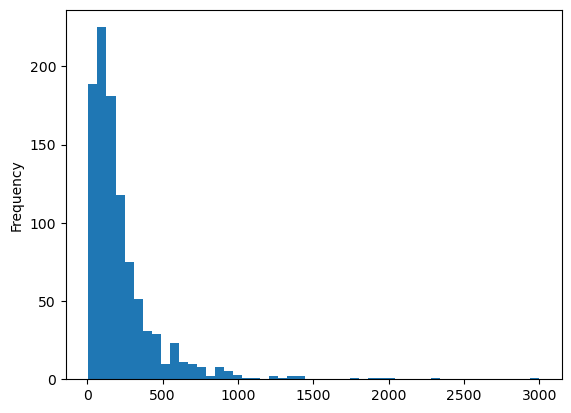

In [8]:
df['length'].plot(bins=50, kind='hist') 

In [9]:
df.length.describe()

count     994.000000
mean      225.484909
std       258.856635
min         8.000000
25%        80.000000
50%       153.000000
75%       268.750000
max      3000.000000
Name: length, dtype: float64

In [10]:
df[df['length'] == 3000]['Review'].iloc[0]

'Im a frequent AirAsia flyer People dont get how they keep things low cost Its like getting an Axia rahmah and complaining about how little you get for such a cheap price They dont give you food extra leg space or check in baggage just to keep costs low No other flight offers prices as low as theirs RM29 from KL to Langkawi RM19 from Kuching to KK RM160 to Bali If you want addons and you can afford it or fly other airlines good for you But for a budget traveler who wants to fly good for them Their taxi time is about 20 minutes meaning people get off once they land new passengers get on board and they go to their next destination They save costs because pilots cabin crew dont have to stay at the destination Because of the tight schedule if anything goes wrong its a domino effect for all their other flights It can range from a malfunction weather crews getting sick or exceeding legal work hours due to delays airport technical issues these will all affect the flights And its not even limi

array([[<Axes: title={'center': 'Negative'}>,
        <Axes: title={'center': 'Neutral'}>],
       [<Axes: title={'center': 'Positive'}>, <Axes: >]], dtype=object)

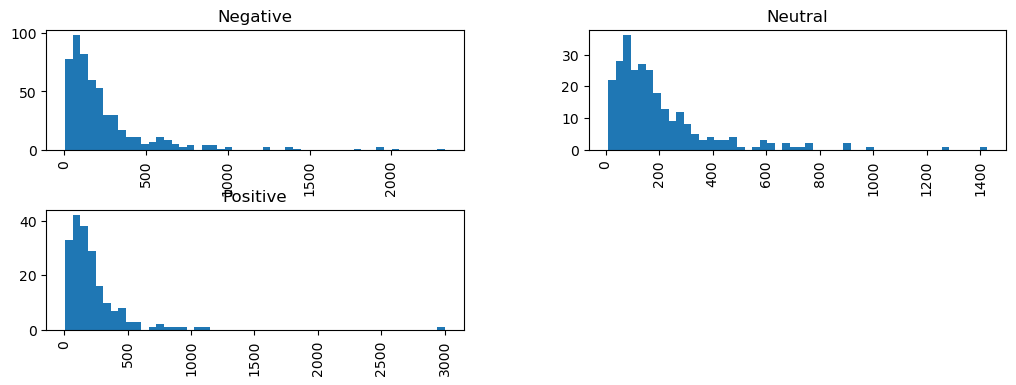

In [11]:
df.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

## Text Preprocessing

In [12]:
import nltk
from nltk.corpus import stopwords

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Athin
[nltk_data]     Suresh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stopwords.words('english')[0:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [15]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)
print(nopunc)

Sample message Notice it has punctuation


In [16]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [17]:
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [19]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [20]:
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


In [21]:
df['Review'].head(5).apply(text_process)

0    [Ive, flown, dozens, times, never, major, issues]
1    [Ive, flown, AirAsia, Thai, AirAsia, AirAsia, ...
2    [flown, several, times, never, problems, weigh...
3    [Within, Thailand, good, experiences, flew, ai...
4                         [experience, AirAsia, Japan]
Name: Review, dtype: object

## Vectorisation

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['Review'])
print(len(bow_transformer.vocabulary_))

4897


In [26]:
review4=df['Review'][3]
print(review4)

Within Thailand I have good experiences with them I flew air Asia x to Japan and it was really bad Cabin staff was honestly nice but ground staff was awful and rude


In [27]:
bow4 = bow_transformer.transform([review4])
print(bow4)
print(bow4.shape)

  (0, 282)	1
  (0, 375)	1
  (0, 670)	1
  (0, 1096)	1
  (0, 1190)	1
  (0, 1303)	1
  (0, 1470)	1
  (0, 1480)	1
  (0, 2372)	1
  (0, 2488)	1
  (0, 2627)	1
  (0, 2646)	1
  (0, 2751)	1
  (0, 3331)	1
  (0, 3769)	1
  (0, 3964)	1
  (0, 4257)	2
  (0, 4850)	1
(1, 4897)


In [28]:
reviews_bow = bow_transformer.transform(df['Review'])
print('Shape of Sparse Matrix: ', reviews_bow.shape)
print('Amount of Non-Zero occurences: ', reviews_bow.nnz)

Shape of Sparse Matrix:  (994, 4897)
Amount of Non-Zero occurences:  20605


## TF_IDF

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(reviews_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 4850)	0.29180137401287054
  (0, 4257)	0.36811768683643614
  (0, 3964)	0.24468637853069258
  (0, 3769)	0.17289636405650702
  (0, 3331)	0.2497376120277759
  (0, 2751)	0.23234886903468882
  (0, 2646)	0.22277915320273503
  (0, 2627)	0.1598939433027906
  (0, 2488)	0.16946365913474434
  (0, 2372)	0.220011359538685
  (0, 1480)	0.1678451305594237
  (0, 1470)	0.25546422825547216
  (0, 1303)	0.15795891205808238
  (0, 1190)	0.30919011700595767
  (0, 1096)	0.20444782463925193
  (0, 670)	0.23608043173069188
  (0, 375)	0.30919011700595767
  (0, 282)	0.11741978663520111


In [33]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['awful']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Asia']])

5.956832588103279
2.7379567632350787


In [34]:
reviews_tfidf = tfidf_transformer.transform(reviews_bow)
print(reviews_tfidf.shape)

(994, 4897)


## Naive Bayes

In [39]:
from sklearn.naive_bayes import MultinomialNB
review_detect_model = MultinomialNB().fit(reviews_tfidf, df['Sentiment'])
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', df['Sentiment'][3])

predicted: Negative
expected: Negative


In [40]:
all_predictions = review_detect_model.predict(reviews_tfidf)
print(all_predictions)

['Positive' 'Negative' 'Positive' 'Negative' 'Negative' 'Negative'
 'Positive' 'Negative' 'Negative' 'Positive' 'Negative' 'Negative'
 'Positive' 'Negative' 'Negative' 'Positive' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Positive' 'Negative' 'Negative'
 'Neutral' 'Negative' 'Negative' 'Negative' 'Positive' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Neutral'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negativ

**Model Evalution**

In [53]:
from sklearn.metrics import classification_report
print (classification_report(df['Sentiment'], all_predictions))

              precision    recall  f1-score   support

    Negative       0.60      1.00      0.75       533
     Neutral       0.96      0.21      0.34       263
    Positive       1.00      0.23      0.38       198

    accuracy                           0.64       994
   macro avg       0.85      0.48      0.49       994
weighted avg       0.78      0.64      0.57       994



## Trying KFOLD

In [50]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Define K-Fold (5 splits)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Convert text to BoW
    ('tfidf', TfidfTransformer()),  # Convert BoW to TF-IDF
    ('classifier', MultinomialNB()),  # Train Naïve Bayes classifier
])

# Loop through each fold
fold_number = 1
for train_index, test_index in kf.split(df):
    rev_train, rev_test = df['Review'].iloc[train_index], df['Review'].iloc[test_index]
    sent_train, sent_test = df['Sentiment'].iloc[train_index], df['Sentiment'].iloc[test_index]

    # Train the pipeline on this fold
    pipeline.fit(rev_train, sent_train)

    # Predict on the test set of this fold
    predictions = pipeline.predict(rev_test)

    # Print classification report for this fold
    print(f"\n🔹 Fold {fold_number} Classification Report:\n")
    print(classification_report(sent_test, predictions))

    fold_number += 1  # Move to the next fold



🔹 Fold 1 Classification Report:

              precision    recall  f1-score   support

    Negative       0.57      1.00      0.73       113
     Neutral       0.00      0.00      0.00        50
    Positive       0.00      0.00      0.00        36

    accuracy                           0.57       199
   macro avg       0.19      0.33      0.24       199
weighted avg       0.32      0.57      0.41       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 2 Classification Report:

              precision    recall  f1-score   support

    Negative       0.48      1.00      0.65        96
     Neutral       1.00      0.02      0.04        56
    Positive       0.00      0.00      0.00        47

    accuracy                           0.49       199
   macro avg       0.49      0.34      0.23       199
weighted avg       0.52      0.49      0.32       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 3 Classification Report:

              precision    recall  f1-score   support

    Negative       0.55      1.00      0.71       109
     Neutral       0.00      0.00      0.00        53
    Positive       1.00      0.03      0.05        37

    accuracy                           0.55       199
   macro avg       0.52      0.34      0.26       199
weighted avg       0.49      0.55      0.40       199


🔹 Fold 4 Classification Report:

              precision    recall  f1-score   support

    Negative       0.57      1.00      0.73       113
     Neutral       0.00      0.00      0.00        44
    Positive       1.00      0.02      0.05        42

    accuracy                           0.57       199
   macro avg       0.52      0.34      0.26       199
weighted avg       0.54      0.57      0.42       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 5 Classification Report:

              precision    recall  f1-score   support

    Negative       0.52      1.00      0.68       102
     Neutral       0.00      0.00      0.00        60
    Positive       1.00      0.03      0.05        36

    accuracy                           0.52       198
   macro avg       0.51      0.34      0.25       198
weighted avg       0.45      0.52      0.36       198



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Stratified KFOLD

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Use Stratified K-Fold to maintain class distribution
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Convert text to BoW
    ('tfidf', TfidfTransformer()),  # Convert BoW to TF-IDF
    ('classifier', MultinomialNB()),  # Train Naïve Bayes classifier
])

# Loop through each fold
fold_number = 1
for train_index, test_index in kf.split(df['Review'], df['Sentiment']):  
    rev_train, rev_test = df['Review'].iloc[train_index], df['Review'].iloc[test_index]
    sent_train, sent_test = df['Sentiment'].iloc[train_index], df['Sentiment'].iloc[test_index]

    # Train the model
    pipeline.fit(rev_train, sent_train)

    # Make predictions
    predictions = pipeline.predict(rev_test)

    # Print classification report
    print(f"\n🔹 Fold {fold_number} Classification Report:\n")
    print(classification_report(sent_test, predictions))

    fold_number += 1



🔹 Fold 1 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       107
     Neutral       0.00      0.00      0.00        52
    Positive       1.00      0.05      0.10        40

    accuracy                           0.55       199
   macro avg       0.51      0.35      0.27       199
weighted avg       0.49      0.55      0.40       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 2 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       106
     Neutral       0.00      0.00      0.00        53
    Positive       1.00      0.03      0.05        40

    accuracy                           0.54       199
   macro avg       0.51      0.34      0.25       199
weighted avg       0.49      0.54      0.38       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 3 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       106
     Neutral       0.00      0.00      0.00        53
    Positive       0.00      0.00      0.00        40

    accuracy                           0.53       199
   macro avg       0.18      0.33      0.23       199
weighted avg       0.29      0.53      0.37       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 4 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       107
     Neutral       0.00      0.00      0.00        53
    Positive       0.00      0.00      0.00        39

    accuracy                           0.54       199
   macro avg       0.18      0.33      0.23       199
weighted avg       0.29      0.54      0.38       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 5 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       107
     Neutral       0.00      0.00      0.00        52
    Positive       1.00      0.03      0.05        39

    accuracy                           0.55       198
   macro avg       0.51      0.34      0.25       198
weighted avg       0.49      0.55      0.39       198



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# BOW_COUNTVEC_TF-IDF_PIPELINE

## EDA

In [1]:
import pandas as pd
data = 'TripleA.csv'
df = pd.read_csv(data)
print(df.columns)
print(df["Sentiment"].value_counts())


Index(['Review', 'Sentiment'], dtype='object')
Sentiment
Negative    533
Neutral     263
Positive    198
Name: count, dtype: int64


In [2]:
valid_sentiments = {"Positive", "Neutral", "Negative"}
unique_sentiments = set(df["Sentiment"].unique())

# Find invalid sentiment labels
invalid_sentiments = unique_sentiments - valid_sentiments

if invalid_sentiments:
    print("Unexpected sentiment labels found:", invalid_sentiments)
    invalid_rows = df[df["Sentiment"].isin(invalid_sentiments)]
    print(invalid_rows)
else:
    print("All sentiments are correctly labeled.")

All sentiments are correctly labeled.


In [3]:
df.describe()

,Review,Sentiment
count,994,994
unique,988,3
top,They are wonderful when they worksB,Negative
freq,2,533


In [4]:
print(df.duplicated(subset="Review").sum())

6


In [5]:
df.groupby('Sentiment').describe()

Review                                                            \
           count unique                                                top   
Sentiment                                                                    
Negative     533    530  Air Asia is the most incompetent airlines Ive ...   
Neutral      263    263  Thieving bass still owe me a 1000 usd I will n...   
Positive     198    198  Ive flown with them dozens of times and never ...   

                
          freq  
Sentiment       
Negative     2  
Neutral      1  
Positive     1

In [6]:
df['length']=df['Review'].apply(len)
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


## Data Visualisation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: ylabel='Frequency'>

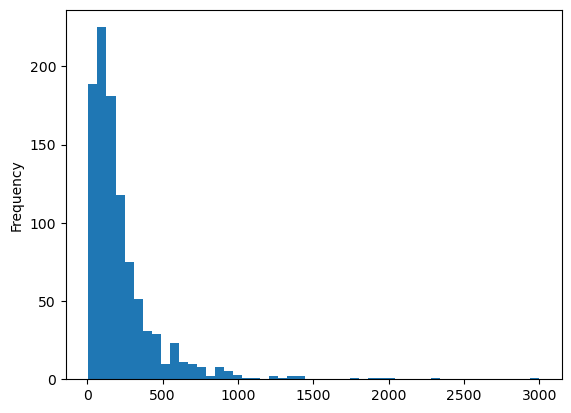

In [8]:
df['length'].plot(bins=50, kind='hist') 

In [9]:
df.length.describe()

count     994.000000
mean      225.484909
std       258.856635
min         8.000000
25%        80.000000
50%       153.000000
75%       268.750000
max      3000.000000
Name: length, dtype: float64

In [10]:
df[df['length'] == 3000]['Review'].iloc[0]

'Im a frequent AirAsia flyer People dont get how they keep things low cost Its like getting an Axia rahmah and complaining about how little you get for such a cheap price They dont give you food extra leg space or check in baggage just to keep costs low No other flight offers prices as low as theirs RM29 from KL to Langkawi RM19 from Kuching to KK RM160 to Bali If you want addons and you can afford it or fly other airlines good for you But for a budget traveler who wants to fly good for them Their taxi time is about 20 minutes meaning people get off once they land new passengers get on board and they go to their next destination They save costs because pilots cabin crew dont have to stay at the destination Because of the tight schedule if anything goes wrong its a domino effect for all their other flights It can range from a malfunction weather crews getting sick or exceeding legal work hours due to delays airport technical issues these will all affect the flights And its not even limi

array([[<Axes: title={'center': 'Negative'}>,
        <Axes: title={'center': 'Neutral'}>],
       [<Axes: title={'center': 'Positive'}>, <Axes: >]], dtype=object)

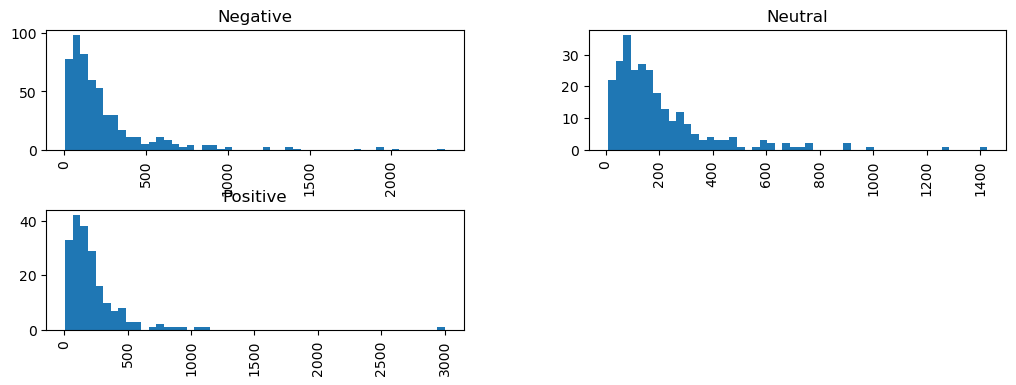

In [11]:
df.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

## Text Preprocessing

In [12]:
import nltk
from nltk.corpus import stopwords

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Athin
[nltk_data]     Suresh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stopwords.words('english')[0:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [15]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)
print(nopunc)

Sample message Notice it has punctuation


In [16]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [17]:
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [19]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [20]:
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


In [21]:
df['Review'].head(5).apply(text_process)

0    [Ive, flown, dozens, times, never, major, issues]
1    [Ive, flown, AirAsia, Thai, AirAsia, AirAsia, ...
2    [flown, several, times, never, problems, weigh...
3    [Within, Thailand, good, experiences, flew, ai...
4                         [experience, AirAsia, Japan]
Name: Review, dtype: object

## Vectorisation

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['Review'])
print(len(bow_transformer.vocabulary_))

4897


In [26]:
review4=df['Review'][3]
print(review4)

Within Thailand I have good experiences with them I flew air Asia x to Japan and it was really bad Cabin staff was honestly nice but ground staff was awful and rude


In [27]:
bow4 = bow_transformer.transform([review4])
print(bow4)
print(bow4.shape)

  (0, 282)	1
  (0, 375)	1
  (0, 670)	1
  (0, 1096)	1
  (0, 1190)	1
  (0, 1303)	1
  (0, 1470)	1
  (0, 1480)	1
  (0, 2372)	1
  (0, 2488)	1
  (0, 2627)	1
  (0, 2646)	1
  (0, 2751)	1
  (0, 3331)	1
  (0, 3769)	1
  (0, 3964)	1
  (0, 4257)	2
  (0, 4850)	1
(1, 4897)


In [28]:
reviews_bow = bow_transformer.transform(df['Review'])
print('Shape of Sparse Matrix: ', reviews_bow.shape)
print('Amount of Non-Zero occurences: ', reviews_bow.nnz)

Shape of Sparse Matrix:  (994, 4897)
Amount of Non-Zero occurences:  20605


## TF_IDF

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(reviews_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 4850)	0.29180137401287054
  (0, 4257)	0.36811768683643614
  (0, 3964)	0.24468637853069258
  (0, 3769)	0.17289636405650702
  (0, 3331)	0.2497376120277759
  (0, 2751)	0.23234886903468882
  (0, 2646)	0.22277915320273503
  (0, 2627)	0.1598939433027906
  (0, 2488)	0.16946365913474434
  (0, 2372)	0.220011359538685
  (0, 1480)	0.1678451305594237
  (0, 1470)	0.25546422825547216
  (0, 1303)	0.15795891205808238
  (0, 1190)	0.30919011700595767
  (0, 1096)	0.20444782463925193
  (0, 670)	0.23608043173069188
  (0, 375)	0.30919011700595767
  (0, 282)	0.11741978663520111


In [33]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['awful']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Asia']])

5.956832588103279
2.7379567632350787


In [34]:
reviews_tfidf = tfidf_transformer.transform(reviews_bow)
print(reviews_tfidf.shape)

(994, 4897)


## Naive Bayes

In [39]:
from sklearn.naive_bayes import MultinomialNB
review_detect_model = MultinomialNB().fit(reviews_tfidf, df['Sentiment'])
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', df['Sentiment'][3])

predicted: Negative
expected: Negative


In [40]:
all_predictions = review_detect_model.predict(reviews_tfidf)
print(all_predictions)

['Positive' 'Negative' 'Positive' 'Negative' 'Negative' 'Negative'
 'Positive' 'Negative' 'Negative' 'Positive' 'Negative' 'Negative'
 'Positive' 'Negative' 'Negative' 'Positive' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Positive' 'Negative' 'Negative'
 'Neutral' 'Negative' 'Negative' 'Negative' 'Positive' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Neutral'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negativ

**Model Evalution**

In [53]:
from sklearn.metrics import classification_report
print (classification_report(df['Sentiment'], all_predictions))

              precision    recall  f1-score   support

    Negative       0.60      1.00      0.75       533
     Neutral       0.96      0.21      0.34       263
    Positive       1.00      0.23      0.38       198

    accuracy                           0.64       994
   macro avg       0.85      0.48      0.49       994
weighted avg       0.78      0.64      0.57       994



## Trying KFOLD

In [50]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Define K-Fold (5 splits)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Convert text to BoW
    ('tfidf', TfidfTransformer()),  # Convert BoW to TF-IDF
    ('classifier', MultinomialNB()),  # Train Naïve Bayes classifier
])

# Loop through each fold
fold_number = 1
for train_index, test_index in kf.split(df):
    rev_train, rev_test = df['Review'].iloc[train_index], df['Review'].iloc[test_index]
    sent_train, sent_test = df['Sentiment'].iloc[train_index], df['Sentiment'].iloc[test_index]

    # Train the pipeline on this fold
    pipeline.fit(rev_train, sent_train)

    # Predict on the test set of this fold
    predictions = pipeline.predict(rev_test)

    # Print classification report for this fold
    print(f"\n🔹 Fold {fold_number} Classification Report:\n")
    print(classification_report(sent_test, predictions))

    fold_number += 1  # Move to the next fold



🔹 Fold 1 Classification Report:

              precision    recall  f1-score   support

    Negative       0.57      1.00      0.73       113
     Neutral       0.00      0.00      0.00        50
    Positive       0.00      0.00      0.00        36

    accuracy                           0.57       199
   macro avg       0.19      0.33      0.24       199
weighted avg       0.32      0.57      0.41       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 2 Classification Report:

              precision    recall  f1-score   support

    Negative       0.48      1.00      0.65        96
     Neutral       1.00      0.02      0.04        56
    Positive       0.00      0.00      0.00        47

    accuracy                           0.49       199
   macro avg       0.49      0.34      0.23       199
weighted avg       0.52      0.49      0.32       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 3 Classification Report:

              precision    recall  f1-score   support

    Negative       0.55      1.00      0.71       109
     Neutral       0.00      0.00      0.00        53
    Positive       1.00      0.03      0.05        37

    accuracy                           0.55       199
   macro avg       0.52      0.34      0.26       199
weighted avg       0.49      0.55      0.40       199


🔹 Fold 4 Classification Report:

              precision    recall  f1-score   support

    Negative       0.57      1.00      0.73       113
     Neutral       0.00      0.00      0.00        44
    Positive       1.00      0.02      0.05        42

    accuracy                           0.57       199
   macro avg       0.52      0.34      0.26       199
weighted avg       0.54      0.57      0.42       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 5 Classification Report:

              precision    recall  f1-score   support

    Negative       0.52      1.00      0.68       102
     Neutral       0.00      0.00      0.00        60
    Positive       1.00      0.03      0.05        36

    accuracy                           0.52       198
   macro avg       0.51      0.34      0.25       198
weighted avg       0.45      0.52      0.36       198



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Stratified KFOLD

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Use Stratified K-Fold to maintain class distribution
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Convert text to BoW
    ('tfidf', TfidfTransformer()),  # Convert BoW to TF-IDF
    ('classifier', MultinomialNB()),  # Train Naïve Bayes classifier
])

# Loop through each fold
fold_number = 1
for train_index, test_index in kf.split(df['Review'], df['Sentiment']):  
    rev_train, rev_test = df['Review'].iloc[train_index], df['Review'].iloc[test_index]
    sent_train, sent_test = df['Sentiment'].iloc[train_index], df['Sentiment'].iloc[test_index]

    # Train the model
    pipeline.fit(rev_train, sent_train)

    # Make predictions
    predictions = pipeline.predict(rev_test)

    # Print classification report
    print(f"\n🔹 Fold {fold_number} Classification Report:\n")
    print(classification_report(sent_test, predictions))

    fold_number += 1



🔹 Fold 1 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       107
     Neutral       0.00      0.00      0.00        52
    Positive       1.00      0.05      0.10        40

    accuracy                           0.55       199
   macro avg       0.51      0.35      0.27       199
weighted avg       0.49      0.55      0.40       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 2 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       106
     Neutral       0.00      0.00      0.00        53
    Positive       1.00      0.03      0.05        40

    accuracy                           0.54       199
   macro avg       0.51      0.34      0.25       199
weighted avg       0.49      0.54      0.38       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 3 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       106
     Neutral       0.00      0.00      0.00        53
    Positive       0.00      0.00      0.00        40

    accuracy                           0.53       199
   macro avg       0.18      0.33      0.23       199
weighted avg       0.29      0.53      0.37       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 4 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       107
     Neutral       0.00      0.00      0.00        53
    Positive       0.00      0.00      0.00        39

    accuracy                           0.54       199
   macro avg       0.18      0.33      0.23       199
weighted avg       0.29      0.54      0.38       199



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Fold 5 Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      1.00      0.70       107
     Neutral       0.00      0.00      0.00        52
    Positive       1.00      0.03      0.05        39

    accuracy                           0.55       198
   macro avg       0.51      0.34      0.25       198
weighted avg       0.49      0.55      0.39       198



C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Athin Suresh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# EDA

In [111]:
!pip install wordcloud
!pip install contractions
!pip install gensim
!pip install xgboost
!pip install pyLDAvis
!pip install imbalanced-learn

In [5]:
import pandas as pd
data = './TripleA.csv'
df = pd.read_csv(data)
print(df.columns)
print(df["Sentiment"].value_counts())

Index(['Review', 'Sentiment'], dtype='object')
Sentiment
Negative    538
Neutral     262
Positive    200
Name: count, dtype: int64


In [7]:
valid_sentiments = {"Positive", "Neutral", "Negative"}
unique_sentiments = set(df["Sentiment"].unique())

# Find invalid sentiment labels
invalid_sentiments = unique_sentiments - valid_sentiments

if invalid_sentiments:
    print("Unexpected sentiment labels found:", invalid_sentiments)
    invalid_rows = df[df["Sentiment"].isin(invalid_sentiments)]
    print(invalid_rows)
else:
    print("All sentiments are correctly labeled.")

All sentiments are correctly labeled.


In [9]:
df.describe()

,Review,Sentiment
count,1000,1000
unique,1000,3
top,Ive flown with them dozens of times and never ...,Negative
freq,1,538


In [11]:
df.groupby('Sentiment').describe()

Review                                                            \
           count unique                                                top   
Sentiment                                                                    
Negative     538    538  Within Thailand I have good experiences with t...   
Neutral      262    262  Thieving bass still owe me a 1000 usd I will n...   
Positive     200    200  Ive flown with them dozens of times and never ...   

                
          freq  
Sentiment       
Negative     1  
Neutral      1  
Positive     1

In [13]:
df['length']=df['Review'].apply(len)
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

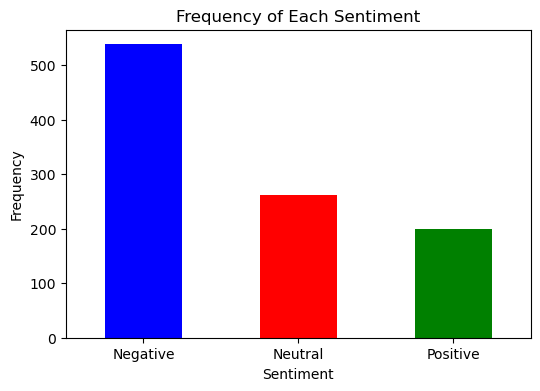

In [16]:
import matplotlib.pyplot as plt

# Count occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Plot bar chart for sentiment distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['blue', 'red', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Frequency of Each Sentiment')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.show()


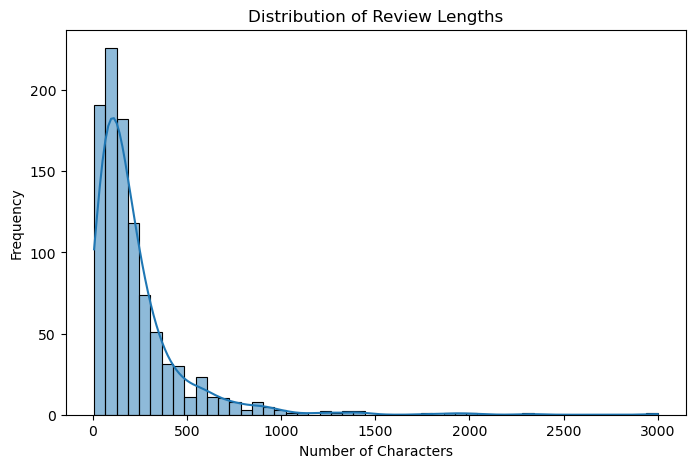

In [17]:
df['Review_Length'] = df['Review'].apply(lambda x: len(str(x)))

# Histogram of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(df['Review_Length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


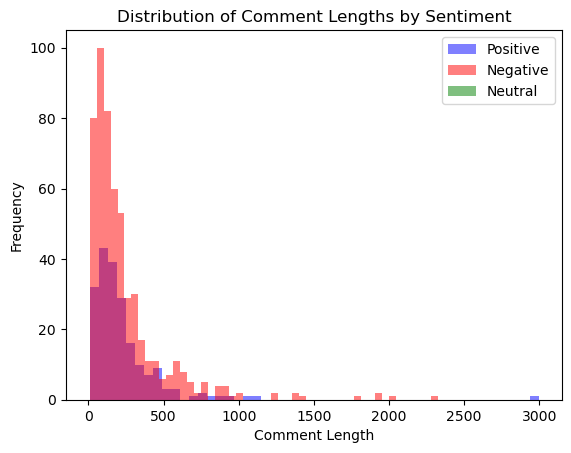

In [18]:
df[df['Sentiment'] == 'Positive']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Positive', color='blue')
df[df['Sentiment'] == 'Negative']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Negative', color='red')
df[df['Sentiment'] == 'neutral']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Neutral', color='green')

plt.legend()
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths by Sentiment')
plt.show()


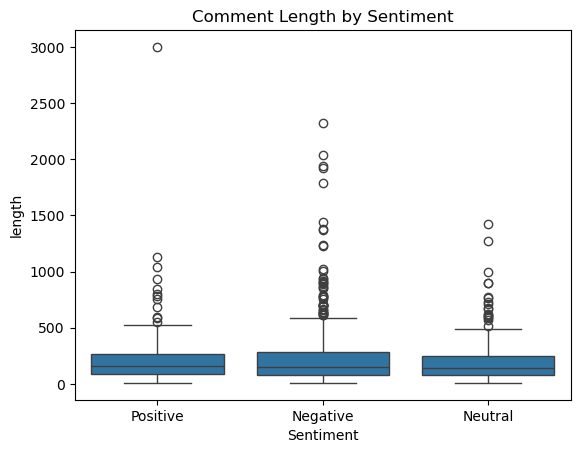

In [19]:
import seaborn as sns

sns.boxplot(x='Sentiment', y='length', data=df)
plt.title('Comment Length by Sentiment')
plt.show()


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

bigrams = get_top_ngrams(df['Review'].dropna(), n=10, ngram_range=(2, 2))
trigrams = get_top_ngrams(df['Review'].dropna(), n=10, ngram_range=(3, 3))

print("Top 10 Bigrams:", bigrams)
print("Top 10 Trigrams:", trigrams)


Top 10 Bigrams: [('air asia', 226), ('customer service', 57), ('budget airlines', 37), ('low cost', 36), ('budget airline', 26), ('credit card', 21), ('ive flown', 19), ('flight delayed', 18), ('pay extra', 15), ('customer support', 14)]
Top 10 Trigrams: [('fly air asia', 13), ('flew air asia', 11), ('low cost airline', 11), ('low cost carrier', 9), ('flown air asia', 7), ('air asia flight', 6), ('air asia worst', 6), ('air asia thailand', 6), ('flying air asia', 5), ('flight delayed hours', 5)]


# Text Preprocessing

## Lowercasing
Convert all text to lowercase to avoid case sensitivity issues.

In [26]:
df['Review'] = df['Review'].str.lower()
df.head()

,Review,Sentiment,length,Review_Length
0,ive flown with them dozens of times and never ...,Positive,66,66
1,ive flown airasia thai airasia and airasia phi...,Positive,77,77
2,i have flown with them several times and never...,Positive,155,155
3,within thailand i have good experiences with t...,Negative,164,164
4,same experience with airasia japan,Negative,34,34


## Removing Punctuation

In [30]:
import string
df['Review'] = df['Review'].str.translate(str.maketrans('', '', string.punctuation))

## Removing Numbers

In [34]:
df['Review'] = df['Review'].str.replace(r'\d+', '', regex=True)

## Removing Stopwords

In [38]:
import nltk
from nltk.corpus import stopwords
import contractions

nltk.download('stopwords')

def expand_and_remove_stopwords(text):
    expanded_text = contractions.fix(text)
    stop_words = set(stopwords.words('english'))
    words = expanded_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['Review'] = df['Review'].apply(expand_and_remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Sentiment,length,Review_Length
0,flown dozens times never major issues,Positive,66,66
1,flown airasia thai airasia airasia philippines...,Positive,77,77
2,flown several times never problems weigh bag t...,Positive,155,155
3,within thailand good experiences flew air asia...,Negative,164,164
4,experience airasia japan,Negative,34,34


## Tokenization

In [40]:
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
df['ReviewTokens'] = df['Review'].apply(word_tokenize)

df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Review,Sentiment,length,Review_Length,ReviewTokens
0,flown dozens times never major issues,Positive,66,66,"[flown, dozens, times, never, major, issues]"
1,flown airasia thai airasia airasia philippines...,Positive,77,77,"[flown, airasia, thai, airasia, airasia, phili..."
2,flown several times never problems weigh bag t...,Positive,155,155,"[flown, several, times, never, problems, weigh..."
3,within thailand good experiences flew air asia...,Negative,164,164,"[within, thailand, good, experiences, flew, ai..."
4,experience airasia japan,Negative,34,34,"[experience, airasia, japan]"


## Lemmatization

In [44]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['ReviewTokens'] = df['ReviewTokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

df.head()

[nltk_data] Downloading package wordnet to /Users/geraint/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review,Sentiment,length,Review_Length,ReviewTokens
0,flown dozens times never major issues,Positive,66,66,"[flown, dozen, time, never, major, issue]"
1,flown airasia thai airasia airasia philippines...,Positive,77,77,"[flown, airasia, thai, airasia, airasia, phili..."
2,flown several times never problems weigh bag t...,Positive,155,155,"[flown, several, time, never, problem, weigh, ..."
3,within thailand good experiences flew air asia...,Negative,164,164,"[within, thailand, good, experience, flew, air..."
4,experience airasia japan,Negative,34,34,"[experience, airasia, japan]"


# Pipelines

In [46]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import gensim.downloader as api
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report

# Used to pass into N-gram and Vector Space
X = df['Review']
y = df['Sentiment']

# Used to pass into word embeddings
X_token = df['ReviewTokens']

# Splitting the dataset to 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Naïve Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = []

## N-gram Features vs. Unigram Features

In [48]:
ngram_models = {
    "Unigram": CountVectorizer(ngram_range=(1, 1)),
    "Bigram": CountVectorizer(ngram_range=(2, 2)),
    "Trigram": CountVectorizer(ngram_range=(3, 3)),
    "Combined N-Grams": CountVectorizer(ngram_range=(1, 3))
}

In [49]:
# Iterate over classifiers and n-gram models
for clf_name, clf in classifiers.items():
    print("=======================================================")
    print(clf_name)
    print("=======================================================")
    for ngram_name, vectorizer in ngram_models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        
        # Train and test the model
        pipeline.fit(X_train, y_train)
        y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print ("---------------------------------------------")
        print(ngram_name)
        print ("---------------------------------------------")
        print (classification_report(y_test, y_pred, zero_division=1))
        
        # Append results to list
        results.append(["N-Gram", clf_name, ngram_name, accuracy, precision, recall, f1])

Logistic Regression
---------------------------------------------
Unigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.82      0.69       117
     Neutral       0.26      0.12      0.17        48
    Positive       0.35      0.17      0.23        35

    accuracy                           0.54       200
   macro avg       0.40      0.37      0.36       200
weighted avg       0.48      0.54      0.49       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Bigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.94      0.73       117
     Neutral       0.42      0.10      0.17        48
    Positive       0.40      0.06      0.10        35

    accuracy                           0.58       200
   macro avg       0.47      0.37      0.33       200
weighted avg       0.52      0.58      0.49       200

Random Forest
---------------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Bigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

Support Vector Machine


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Unigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Bigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

Naïve Bayes
---------------------------------------------
Unigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.61      0.86      0.72       117
     Neutral       0.28      0.15      0.19        48
    Positive       0.40      0.11      0.18        35

    accuracy                           0.56       200
   macro avg       0.43      0.37      0.36       200
weighted avg       0.50      0.56      0.50       200

-----------------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.59      0.99      0.74       117
     Neutral       0.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.53      0.33      0.25       200
weighted avg       0.52      0.58      0.43       200

---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.97      0.74       117
     Neutral       0.45      0.10      0.17        48
    Positive       0.00      0.00      0.00        35

    accuracy                           0.59       200
   macro avg       0.35      0.36      0.30       200
weighted avg       0.46      0.59      0.48       200

Gradient Boosting
-----------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.59      0.87      0.70       117
     Neutral       0.12      0.04      0.06        48
    Positive       0.09      0.03      0.04        35

    accuracy                           0.53       200
   macro avg       0.27      0.31      0.27       200
weighted avg       0.39      0.53      0.43       200



## Vector Space 

In [52]:
vector_space_models = {
    "Binary Representation": CountVectorizer(binary=True),
    "Frequency Count": CountVectorizer(max_features=10000, max_df=.15),
    "TF-IDF": TfidfVectorizer(max_features=10000, max_df=.15)
}

In [53]:
for clf_name, clf in classifiers.items():
    print("=======================================================")
    print(clf_name)
    print("=======================================================")
    for vector_name, vectorizer in vector_space_models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')   
        print ("---------------------------------------------")
        print(vector_name)
        print ("---------------------------------------------")
        print (classification_report(y_test, y_pred, zero_division=1))
        
        # Append results to list
        results.append(["Vector Space", clf_name, vector_name, accuracy, precision, recall, f1])

Logistic Regression
---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.84      0.70       117
     Neutral       0.17      0.08      0.11        48
    Positive       0.43      0.17      0.24        35

    accuracy                           0.54       200
   macro avg       0.40      0.36      0.35       200
weighted avg       0.47      0.54      0.48       200

---------------------------------------------
Frequency Count
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.86      0.71       117
     Neutral       0.33      0.12      0.18        48
    Positive       0.33      0.14      0.20        35

    accuracy                           0.56       200
   macro avg       0.42      0.38      0.36       200
weighted avg       0.49      0.56      0.49       2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      0.89      0.70       117
     Neutral       0.17      0.04      0.07        48
    Positive       0.00      0.00      0.00        35

    accuracy                           0.53       200
   macro avg       0.25      0.31      0.26       200
weighted avg       0.38      0.53      0.43       200

---------------------------------------------
Frequency Count
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.59      0.90      0.71       117
     Neutral       0.29      0.08      0.13        48
    Positive       0.11      0.03      0.05        35

    accuracy                           0.55       200
   macro avg       0.33      0.34      0.30       200
weighted avg       0.44      0.55      0.46       200

----------------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Frequency Count
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
TF-IDF
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

Naïve Bayes
---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.63      0.89      0.73       117
     Neutral       0.33      0.15      0.20        48
    Positive       0.31      0.11      0.17        35

    accuracy                           0.57       200
   macro avg       0.42      0.38      0.37       200
weighted avg       0.50      0.57      0.51       200

-------------

## Word Embeddings

In [57]:
classifiers1 = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [58]:
# Load pretrained Word2Vec (Google News)
word2vec = api.load("word2vec-google-news-300")

# Load pretrained GloVe
glove_vectors = api.load("glove-twitter-25")

# Function to convert text to word embeddings
def get_embedding(tokens, model):
    """
    Generates an average word embedding for a list of tokens.
    """
    word_vectors = [model[word] for word in tokens if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Convert text data to embeddings
X_word2vec = np.array([get_embedding(text, word2vec) for text in X_token])
X_glove = np.array([get_embedding(text, glove_vectors) for text in X_token])

# Train-test split for word embeddings
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y, test_size=0.2, random_state=42)

# Test classifiers on word embeddings
for clf_name, clf in classifiers1.items():
    print("=======================================================")
    print(clf_name)
    print("=======================================================")
    # Word2Vec
    clf.fit(X_train_w2v, y_train_w2v)
    y_pred_w2v = clf.predict(X_test_w2v)
    
    # Evaluate
    accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
    precision_w2v = precision_score(y_test_w2v, y_pred_w2v, average='weighted')
    recall_w2v = recall_score(y_test_w2v, y_pred_w2v, average='weighted')
    f1_w2v = f1_score(y_test_w2v, y_pred_w2v, average='weighted')

    print ("---------------------------------------------")
    print("Word2Vec")
    print ("---------------------------------------------")
    print (classification_report(y_test_w2v, y_pred_w2v, zero_division=1))
    
    results.append(["Word Embedding", clf_name, "Word2Vec", accuracy_w2v, precision_w2v, recall_w2v, f1_w2v])
    
    # GloVe
    clf.fit(X_train_glove, y_train_glove)
    y_pred_glove = clf.predict(X_test_glove)
    
    # Evaluate
    accuracy_glove = accuracy_score(y_test_glove, y_pred_glove)
    precision_glove = precision_score(y_test_glove, y_pred_glove, average='weighted')
    recall_glove = recall_score(y_test_glove, y_pred_glove, average='weighted')
    f1_glove = f1_score(y_test_glove, y_pred_glove, average='weighted')

    print ("---------------------------------------------")
    print("GloVe")
    print ("---------------------------------------------")
    print (classification_report(y_test_glove, y_pred_glove, zero_division=1))
    
    results.append(["Word Embedding", clf_name, "GloVe", accuracy_glove, precision_glove, recall_glove, f1_glove])

Logistic Regression
---------------------------------------------
Word2Vec
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.71      0.91      0.80       117
     Neutral       0.57      0.35      0.44        48
    Positive       0.62      0.37      0.46        35

    accuracy                           0.68       200
   macro avg       0.63      0.54      0.57       200
weighted avg       0.66      0.68      0.65       200

---------------------------------------------
GloVe
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.63      0.90      0.74       117
     Neutral       0.38      0.06      0.11        48
    Positive       0.48      0.34      0.40        35

    accuracy                           0.60       200
   macro avg       0.49      0.43      0.42       200
weighted avg       0.54      0.60      0.53       200

Random Forest
-----

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Word2Vec
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.72      0.84      0.77       117
     Neutral       0.42      0.38      0.40        48
    Positive       0.45      0.26      0.33        35

    accuracy                           0.62       200
   macro avg       0.53      0.49      0.50       200
weighted avg       0.60      0.62      0.60       200

---------------------------------------------
GloVe
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.62      0.74      0.67       117
     Neutral       0.29      0.17      0.21        48
    Positive       0.30      0.29      0.29        35

    accuracy                           0.52       200
   macro avg       0.40      0.40      0.39       200
weighted avg       0.48      0.52      0.50       200



In [59]:
# Convert results into a DataFrame
df_results = pd.DataFrame(results, columns=["Representation Type", "Classifier", "Feature Type", "Accuracy", "Precision", "Recall", "F1-Score"])

# Apply styling
styled_df = df_results.style.format(precision=4).highlight_max(subset=["Accuracy", "Precision", "Recall", "F1-Score"])

# Display the styled table
display(styled_df)

,Representation Type,Classifier,Feature Type,Accuracy,Precision,Recall,F1-Score
0,N-Gram,Logistic Regression,Unigram,0.5400,0.4754,0.5400,0.4864
1,N-Gram,Logistic Regression,Bigram,0.5850,0.3422,0.5850,0.4318
2,N-Gram,Logistic Regression,Trigram,0.5850,0.3422,0.5850,0.4318
3,N-Gram,Logistic Regression,Combined N-Grams,0.5850,0.5216,0.5850,0.4865
4,N-Gram,Random Forest,Unigram,0.5750,0.4833,0.5750,0.4768
5,N-Gram,Random Forest,Bigram,0.5850,0.3422,0.5850,0.4318
6,N-Gram,Random Forest,Trigram,0.5850,0.3422,0.5850,0.4318
7,N-Gram,Random Forest,Combined N-Grams,0.5850,0.3422,0.5850,0.4318
8,N-Gram,Support Vector Machine,Unigram,0.5850,0.3422,0.5850,0.4318
9,N-Gram,Support Vector Machine,Bigram,0.5850,0.3422,0.5850,0.4318


# Visualization and Insights

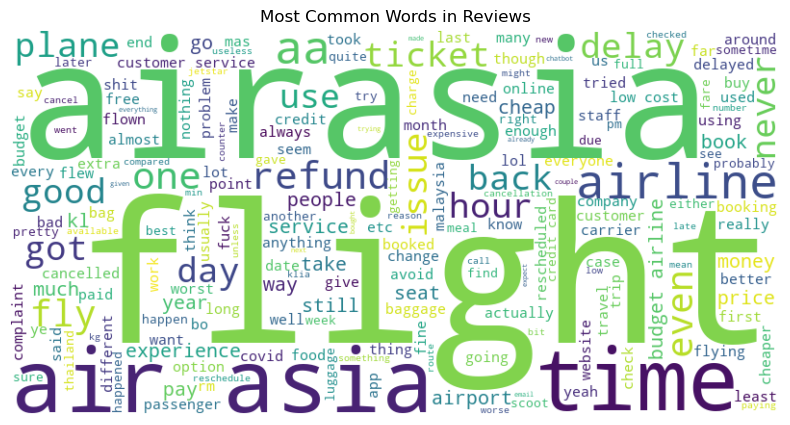

In [61]:
from wordcloud import WordCloud

# Combine all reviews
all_words = ' '.join(df['Review'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()


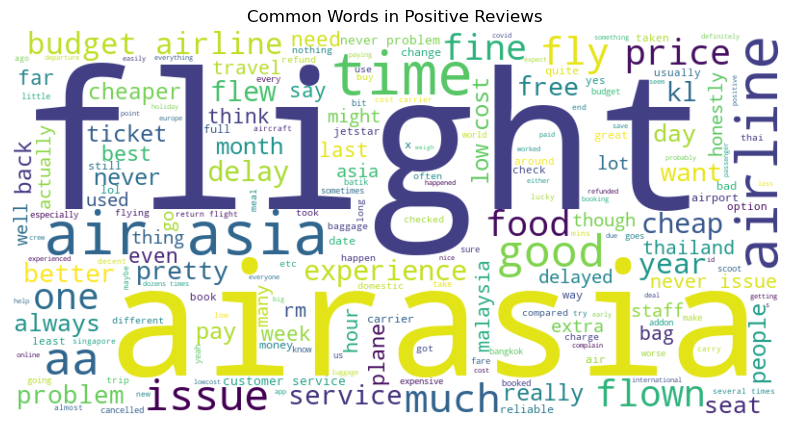

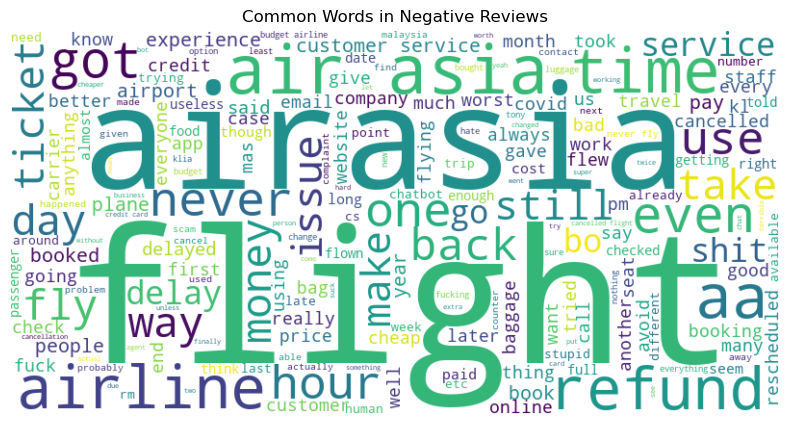

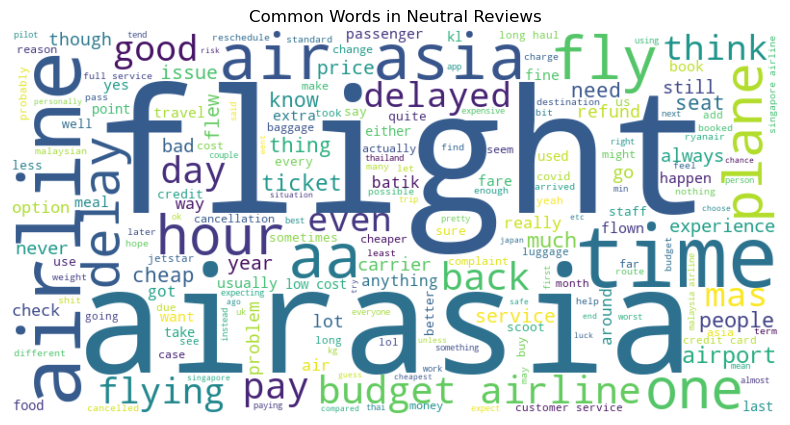

In [62]:
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['Review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Common Words in {sentiment} Reviews')
    plt.show()


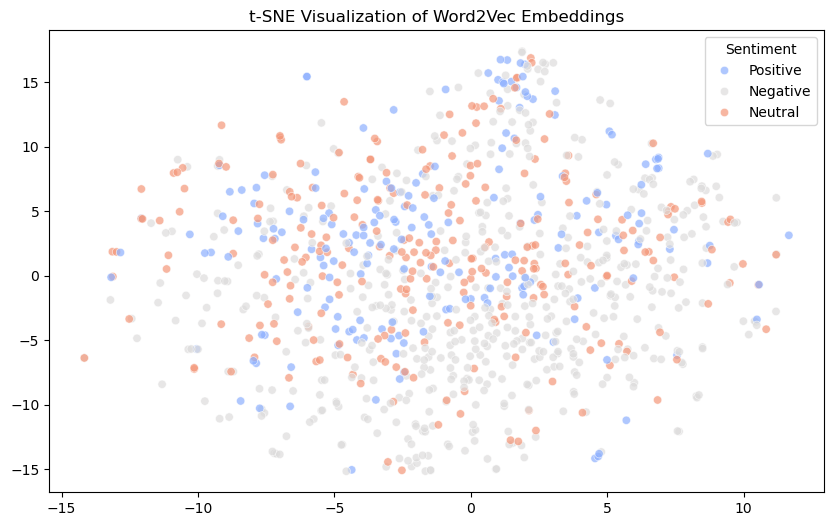

In [63]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality of Word2Vec embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_word2vec)  # Replace with X_glove for GloVe

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()


In [64]:
positive_review = df[df['Sentiment'] == 'Positive']
negative_review = df[df['Sentiment'] == 'Negative']

In [65]:
from collections import Counter

# Define words to exclude
exclude_words = {'airasia', 'aa', 'asia', 'air', 'flight', 'airline'}

# Flatten and filter words for positive and negative reviews
positive_words = [word for tokens in positive_review['ReviewTokens'] 
                  for word in tokens if word.lower() not in exclude_words]
negative_words = [word for tokens in negative_review['ReviewTokens'] 
                  for word in tokens if word.lower() not in exclude_words]

# Count word frequencies
common_positive = Counter(positive_words).most_common(10)
common_negative = Counter(negative_words).most_common(10)

print("Most common words in Positive reviews:", common_positive)
print("Most common words in Negative reviews:", common_negative)


Most common words in Positive reviews: [('time', 75), ('issue', 43), ('never', 39), ('get', 36), ('like', 35), ('good', 34), ('service', 31), ('budget', 30), ('problem', 29), ('much', 27)]
Most common words in Negative reviews: [('time', 122), ('get', 111), ('refund', 95), ('service', 77), ('never', 76), ('customer', 75), ('fly', 72), ('would', 71), ('even', 69), ('got', 68)]


In [66]:
import gensim
import pyLDAvis
import pyLDAvis.gensim
from gensim import corpora

pyLDAvis.enable_notebook()

In [67]:
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import gensim

positive_reviews = df[df['Sentiment'] == "Positive"]['ReviewTokens'].tolist()
negative_reviews = df[df['Sentiment'] == "Negative"]['ReviewTokens'].tolist()

positive_reviews = [eval(tokens) if isinstance(tokens, str) else tokens for tokens in positive_reviews]
negative_reviews = [eval(tokens) if isinstance(tokens, str) else tokens for tokens in negative_reviews]

def train_lda(reviews, num_topics):
    dictionary = corpora.Dictionary(reviews)
    corpus = [dictionary.doc2bow(text) for text in reviews]
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2)
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return vis

lda_normal = train_lda(df['ReviewTokens'].tolist(), 5)
pyLDAvis.display(lda_normal)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31750) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31750) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31750) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31750) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

In [68]:
lda_vis_negative = train_lda(negative_reviews, 5)
pyLDAvis.display(lda_vis_negative) 

In [69]:
lda_vis_positive = train_lda(positive_reviews, 5)
pyLDAvis.display(lda_vis_positive)